# HW1: Autoregressive Models

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [3]:
X = sample_data()
print('X: ', X.shape)
nrof_test_samples = int(X.shape[0]*0.2)
nrof_val_samples = int(X.shape[0]*0.1)

X_train = X[:-(nrof_val_samples+nrof_test_samples)]
X_val = X[-(nrof_test_samples+nrof_val_samples):-nrof_test_samples]
X_test = X[-nrof_test_samples:]
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)

X:  (10000,)
X_train:  (7000,)
X_val:  (1000,)
X_test:  (2000,)


(array([  16.,   30.,   72.,  179.,  273.,  417.,  384.,  590.,  525.,
         420.,  275.,  172.,   69.,   41.,   18.,    5.,   14.,  100.,
         248.,  789., 1137.,  842.,  311.,   63.,   10.]),
 array([ 1.  ,  4.84,  8.68, 12.52, 16.36, 20.2 , 24.04, 27.88, 31.72,
        35.56, 39.4 , 43.24, 47.08, 50.92, 54.76, 58.6 , 62.44, 66.28,
        70.12, 73.96, 77.8 , 81.64, 85.48, 89.32, 93.16, 97.  ]),
 <a list of 25 Patch objects>)

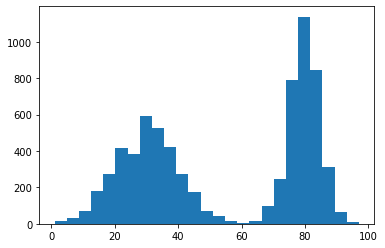

In [4]:
plt.hist(X_train, 25)

Fit pθ with maximum likelihood via stochastic gradient descent on the training set, using θ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice. Provide these deliverables:

1. Over the course of training, record the average negative log likelihood of the training data
(per minibatch) and validation data (for your entire validation set). Plot both on the same
graph – the x-axis should be training steps, and the y-axis should be negative log likelihood;
feel free to compute and report the validation performance less frequently. Report the test
set performance of your final model. Be sure to report all negative log likelihoods in bits.
2. Plot the model probabilities in a bar graph, with {1, . . . , 100} on the x-axis and a real number
in [0, 1] on the y-axis. Next, draw 1000 samples from your model, and plot their empirical
frequencies on a new bar graph with the same axes. How do both plots compare visually to
the data distribution?

In [5]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [6]:
def log2(x):
    return tf.log(x) / tf.log(2.0)

def create_model(x, nrof_dims=100):
    theta = tf.get_variable(name='theta', shape=(nrof_dims,), dtype=tf.float32, initializer=tf.zeros_initializer, trainable=True)
    th = tf.gather(theta, x)
    prob = tf.math.exp(th) / tf.reduce_sum(tf.math.exp(theta))
    loss = -tf.reduce_mean(log2(prob))
    return loss, prob

In [7]:
with tf.Graph().as_default():

    batch_size = 100
    train_iterator = create_dataset(X_train, batch_size)
    val_iterator = create_dataset(X_val, batch_size)
    test_iterator = create_dataset(X_test, batch_size)
    x_ph = tf.placeholder(tf.int64, shape=(None,))
    
    with tf.compat.v1.variable_scope('model', reuse=tf.AUTO_REUSE):
        train_loss, _ = create_model(train_iterator.get_next())
        val_loss, _ = create_model(val_iterator.get_next())
        test_loss, _ = create_model(test_iterator.get_next())
        _, prob = create_model(x_ph)

        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(train_loss)

        sess  = tf.compat.v1.InteractiveSession()
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(train_iterator.initializer)
        sess.run(val_iterator.initializer)
        sess.run(test_iterator.initializer)
        
        nrof_train_batches = X_train.shape[0] // batch_size

        nrof_epochs = 100
        train_loss_list = []
        val_loss_list = []
        for epoch in range(1, nrof_epochs+1):
            for i in range(nrof_train_batches):
                _, loss_ = sess.run([train_op, train_loss])
                train_loss_list += [ loss_ ]
            print('train epoch: %d  loss: %.3f' % (epoch, loss_))
            vl = []
            for i in range(X_val.shape[0] // batch_size):
                loss_ = sess.run(val_loss)
                vl += [ loss_ ]
            val_loss_mean = np.mean(vl)
            val_loss_list += [ val_loss_mean ]
            print('val epoch: %d  loss: %.3f' % (epoch, val_loss_mean))

        test_loss_list = []
        for i in range(X_test.shape[0] // batch_size):
            loss_ = sess.run([test_loss])
            test_loss_list += [ loss_ ]
        print('test epoch: %d  loss: %.3f' % (epoch, np.mean(test_loss_list)))

train epoch: 1  loss: 6.187
val epoch: 1  loss: 6.167
train epoch: 2  loss: 6.042
val epoch: 2  loss: 5.971
train epoch: 3  loss: 6.030
val epoch: 3  loss: 5.914
train epoch: 4  loss: 5.807
val epoch: 4  loss: 5.875
train epoch: 5  loss: 5.778
val epoch: 5  loss: 5.902
train epoch: 6  loss: 5.986
val epoch: 6  loss: 5.873
train epoch: 7  loss: 5.945
val epoch: 7  loss: 5.835
train epoch: 8  loss: 5.841
val epoch: 8  loss: 5.866
train epoch: 9  loss: 5.872
val epoch: 9  loss: 5.780
train epoch: 10  loss: 5.729
val epoch: 10  loss: 5.821
train epoch: 11  loss: 5.807
val epoch: 11  loss: 5.899
train epoch: 12  loss: 6.156
val epoch: 12  loss: 5.886
train epoch: 13  loss: 5.881
val epoch: 13  loss: 5.839
train epoch: 14  loss: 5.904
val epoch: 14  loss: 5.823
train epoch: 15  loss: 5.801
val epoch: 15  loss: 5.827
train epoch: 16  loss: 5.664
val epoch: 16  loss: 5.818
train epoch: 17  loss: 5.884
val epoch: 17  loss: 5.829
train epoch: 18  loss: 5.838
val epoch: 18  loss: 5.844
train epoc

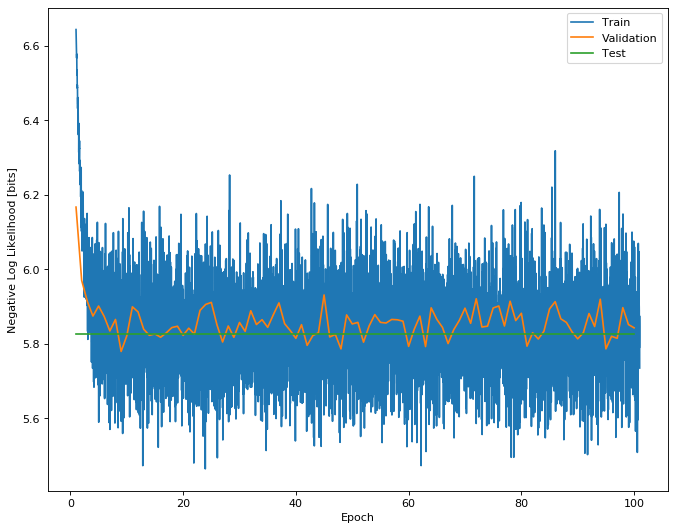

In [8]:
plt.figure(figsize=(10, 8), dpi= 80)
plt.plot(np.arange(1, nrof_epochs+1, 1/nrof_train_batches), train_loss_list)
plt.plot(np.arange(1, nrof_epochs+1), val_loss_list)
plt.plot(np.arange(1, nrof_epochs+1), np.mean(test_loss_list)*np.ones((nrof_epochs)))
plt.ylabel('Negative Log Likelihood [bits]')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation', 'Test'])

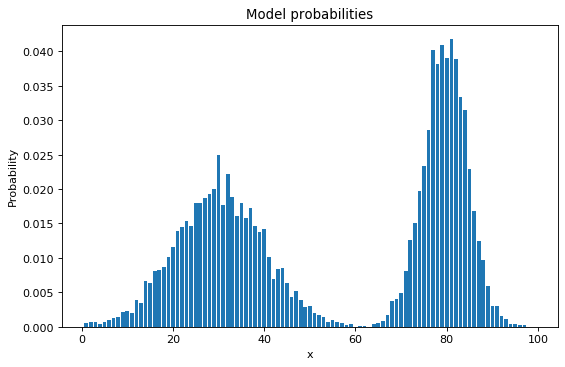

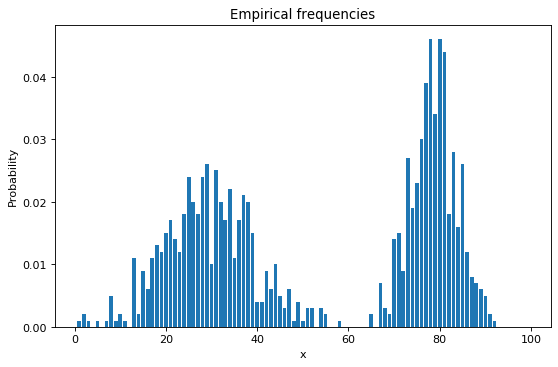

In [9]:
plt.figure(figsize=(8, 5), dpi= 80)
x = np.arange(1,100)
prob_ = sess.run(prob, feed_dict={x_ph: x})
plt.bar(x, prob_)
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Model probabilities')
plt.figure(figsize=(8, 5), dpi= 80)

y = np.random.choice(99, size=(1000,), p=prob_)
a, b = np.histogram(y, bins=np.arange(1,101))
z = np.arange(1,100)
plt.bar(z, a / np.sum(a))
plt.xlabel('x')
plt.ylabel('Probability')
_ = plt.title('Empirical frequencies')